In [ ]:
#!pip install matplotlib
#!pip install opensimplex
#!pip install scipy

In [1]:
%matplotlib widget
import os
import csv
import random
from pathlib import Path
import pandas as pd
import numpy as np
#import matplotlib
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import opensimplex
from scipy.spatial import KDTree

mpl.rcParams['axes3d.mouserotationstyle'] = 'azel'

sample_dist=1

#%matplotlib inline

hole_indexes = ['2-5', '2-6', '3-2', '3-3', '4-5']
filenames = [idx + " - Borehole Deviation Data_accurate.csv" for idx in hole_indexes]

#source_folder = Path(r'C:\Users\howar\OneDrive - ballingercloud\Documents\umb boreholes')
source_folder = Path(r'C:\Users\DHoward\OneDrive - ballingercloud\Documents\umb boreholes')
filepaths = [source_folder / fn for fn in filenames]

### Dataframe parameters
 - idx - Index of measurement
 - dz, dy, dx - XYZ coordinates of measurement, relative to origin of borehole
 - total_dev_ft, total_dev_pct - from original data, total deviation
 - delta_dx, delta_dy, delta_dz - difference in XYZ coordinate from previous point, ie: the vector coordinates of the move from one point to another
 - ddx, ddy, ddz - difference in amount of change from previous point - ie: did the move between points change direction or stay the same
   - asdfaf

In [2]:
def process_borehole(filepath, hole_index):
    df = pd.read_csv(filepath)
    df.dropna(inplace=True)
    df = df.set_axis(['idx', 'z', 'y', 'x', 'total_dev_ft', 'total_dev_pct'], axis=1)
    df = df[0::sample_dist] # only getting entries every <sample_dist> linear feet, could remove for every 1 foot spacing
    df.insert(1, 'hole_index', hole_index)
    
    df['position_angle'] = np.arctan2(df['y'], df['x'])
    
    df['delta_x'] = df['x'] - df['x'].shift(1, fill_value=None)
    df['delta_y'] = df['y'] - df['y'].shift(1, fill_value=None)
    df['delta_z'] = df['z'] - df['z'].shift(1, fill_value=None)
    df['velocity_angle'] = np.arctan2(df['delta_y'], df['delta_x'])

    # to get the change in direction, need to get the difference between this delta and previous delta

    df['ddx'] = df['delta_x'] - df['delta_x'].shift(1, fill_value=None)
    df['ddy'] = df['delta_y'] - df['delta_y'].shift(1, fill_value=None)
    df['ddz'] = df['delta_z'] - df['delta_z'].shift(1, fill_value=None)
    df['acceleration_angle'] = np.arctan2(df['ddy'], df['ddx'])

    df['jx'] = df['ddx'] - df['ddx'].shift(1, fill_value=None)
    df['jy'] = df['ddy'] - df['ddy'].shift(1, fill_value=None)
    df['jz'] = df['ddz'] - df['ddz'].shift(1, fill_value=None)

    df['abs_ddx'] = df['ddx'].abs()
    df['abs_ddy'] = df['ddy'].abs()
    df['abs_ddz'] = df['ddz'].abs()

    df['d_dist'] = np.sqrt(
        (df['x'] - df['x'].shift(1))**2 +
        (df['y'] - df['y'].shift(1))**2 +
        (df['z'] - df['z'].shift(1))**2
    )
    df['d_dist_error'] = (df['d_dist'] - 10).abs()

    return df

total_stats = pd.DataFrame()
for fp, hi in zip(filepaths, hole_indexes):
    #print(fp, hi)
    df = process_borehole(fp, hi)
    #print(df.loc[0:1])
    df = df[3:]
    total_stats = pd.concat([total_stats, df])

#total_stats = total_stats.set_index(['idx', 'hole_index']) 
total_stats = total_stats.reset_index().drop('index', axis=1)
total_stats[['idx', 'hole_index', 'x', 'y', 'z', 'position_angle', 'delta_x', 'delta_y', 'delta_z', 'ddx', 'ddy', 'ddz', 'jx', 'jy', 'jz']]


,idx,hole_index,x,y,z,position_angle,delta_x,delta_y,delta_z,ddx,ddy,ddz,jx,jy,jz
0,3,2-5,0.01822,0.01529,2.99988,0.698183,0.00825,0.00692,0.99993,0.00270,0.00226,-4.000000e-05,0.00157,1.310000e-03,-3.000000e-05
1,4,2-5,0.02614,0.02193,3.99982,0.698040,0.00792,0.00664,0.99994,-0.00033,-0.00028,1.000000e-05,-0.00303,-2.540000e-03,5.000000e-05
2,5,2-5,0.03371,0.02829,4.99977,0.698200,0.00757,0.00636,0.99995,-0.00035,-0.00028,1.000000e-05,-0.00002,-6.938894e-18,-2.220446e-16
3,6,2-5,0.04237,0.03555,5.99970,0.698095,0.00866,0.00726,0.99993,0.00109,0.00090,-2.000000e-05,0.00144,1.180000e-03,-3.000000e-05
4,7,2-5,0.05221,0.04381,6.99961,0.698139,0.00984,0.00826,0.99991,0.00118,0.00100,-2.000000e-05,0.00009,1.000000e-04,-4.440892e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3023,606,4-5,61.96540,59.86130,598.48600,0.768129,0.17050,0.15040,0.97300,-0.00750,-0.00910,-1.136868e-13,-0.01440,-2.400000e-02,1.000000e-03
3024,607,4-5,62.13770,60.01090,599.45900,0.767988,0.17230,0.14960,0.97300,0.00180,-0.00080,0.000000e+00,0.00930,8.300000e-03,1.136868e-13
3025,608,4-5,62.31080,60.16240,600.43200,0.767858,0.17310,0.15150,0.97300,0.00080,0.00190,1.136868e-13,-0.00100,2.700000e-03,1.136868e-13
3026,609,4-5,62.49240,60.31860,601.40400,0.767700,0.18160,0.15620,0.97200,0.00850,0.00470,-1.000000e-03,0.00770,2.800000e-03,-1.000000e-03


## Visualize Overall Stats

In [ ]:
selected_borehole = hole_indexes[0]
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='x', y='y', title='horizontal position')
#total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y='position_angle', title='position angle over depth', ylim=(-3.14, 3.14))
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y=['delta_x','delta_y'], title='change in position over depth', marker='o')
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y=['ddx','ddy'], title='change in acceleration over depth', marker='o')
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y=['jx','jy'], title='jerk over depth', marker='o')


In [ ]:
total_stats[total_stats['hole_index'] == '2-5'].hist(column='angle', bins=np.arange(-4, 4, 0.2))

In [ ]:
total_stats.hist(column=['ddx', 'ddy', 'ddz'], bins=np.arange(-0.2,0.2, 0.01))

In [ ]:
total_stats[total_stats['hole_index'] == '2-5'].plot.line(x='idx', y='ddx', marker='o')

## Simulation

### Simulate Borehole function


In [21]:
def get_delta_z(delta_x, delta_y, dist):
    delta_z = np.sqrt(dist**2 - delta_x**2 - delta_y**2) * -1 # change in z direction is always down
    return delta_z
    
def simulate_borehole(sample_dist, origin_x = 0.0, origin_y = 0.0):
    dist = sample_dist
    df = pd.DataFrame(
        {'idx': [0],
         'x': [origin_x], 'y': [origin_y], 'z': [0.0],
         'delta_x': [0.0], 'delta_y': [0.0], 'delta_z': [0.0],
         'ddx': [0.0], 'ddy': [0.0], 'ddz': [0.0]
        }
    )
    #rand_x = np.random.choice([-1, 1])
    #rand_y = np.random.choice([-1, 1])
    rand_x = 1
    rand_y = 1
    for i in range(600):
        idx = i+1
        new_i = len(df)
        df.loc[new_i] = df.loc[new_i-1]
        df.loc[new_i, 'idx'] = idx
        ddx = np.random.choice(total_stats['ddx']) * rand_x
        ddy = np.random.choice(total_stats['ddy']) * rand_y
        df.loc[new_i, 'ddx'] = ddx 
        df.loc[new_i, 'ddy'] = ddy 
        df.loc[new_i, 'delta_x'] = df.loc[new_i, 'delta_x'] + ddx
        df.loc[new_i, 'delta_y'] = df.loc[new_i, 'delta_y'] + ddy
        delta_z = get_delta_z(df.loc[new_i, 'delta_x'], df.loc[new_i, 'delta_y'], dist)
        df.loc[new_i, 'delta_z'] = delta_z

        df.loc[new_i, 'x'] = df.loc[new_i, 'x'] + df.loc[new_i, 'delta_x']
        df.loc[new_i, 'y'] = df.loc[new_i, 'y'] + df.loc[new_i, 'delta_y']
        df.loc[new_i, 'z'] = df.loc[new_i, 'z'] + df.loc[new_i, 'delta_z']
    return df


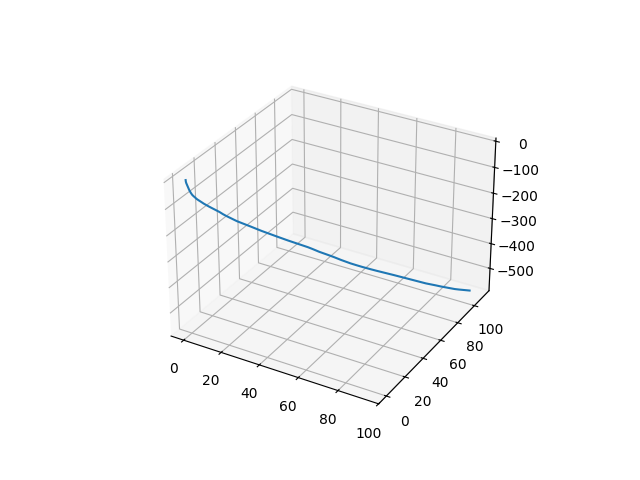

,idx,x,y,z,delta_x,delta_y,delta_z,ddx,ddy,ddz
0,0.0,0.00000,0.00000,0.000000,0.00000,0.0000,0.000000,0.00000,0.0000,0.0
1,1.0,0.00190,0.00470,-0.999987,0.00190,0.0047,-0.999987,0.00190,0.0047,0.0
2,2.0,0.00519,0.00870,-1.999974,0.00329,0.0040,-0.999987,0.00139,-0.0007,0.0
3,3.0,0.00598,0.01390,-2.999960,0.00079,0.0052,-0.999986,-0.00250,0.0012,0.0
4,4.0,0.00927,0.02040,-3.999933,0.00329,0.0065,-0.999973,0.00250,0.0013,0.0
...,...,...,...,...,...,...,...,...,...,...
596,596.0,92.31890,108.64174,-575.694755,0.24235,0.3486,-0.905397,0.00110,0.0017,0.0
597,597.0,92.55905,108.98664,-576.602154,0.24015,0.3449,-0.907398,-0.00220,-0.0037,0.0
598,598.0,92.80310,109.33204,-577.508321,0.24405,0.3454,-0.906167,0.00390,0.0005,0.0
599,599.0,93.04695,109.68574,-578.411334,0.24385,0.3537,-0.903014,-0.00020,0.0083,0.0


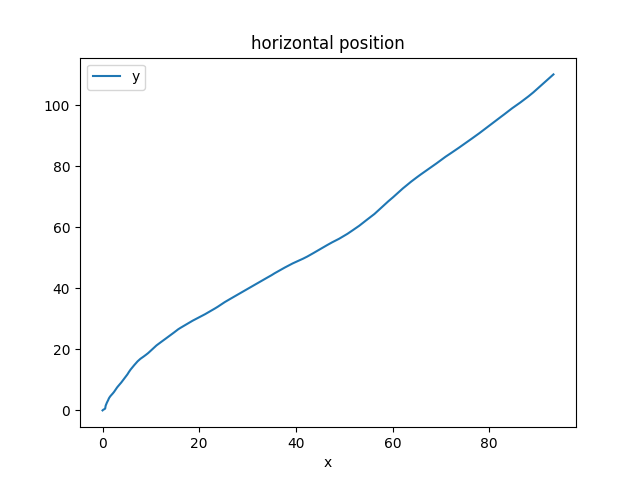

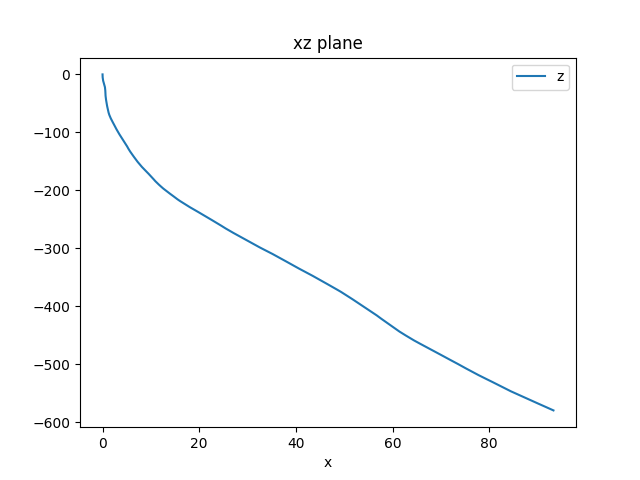

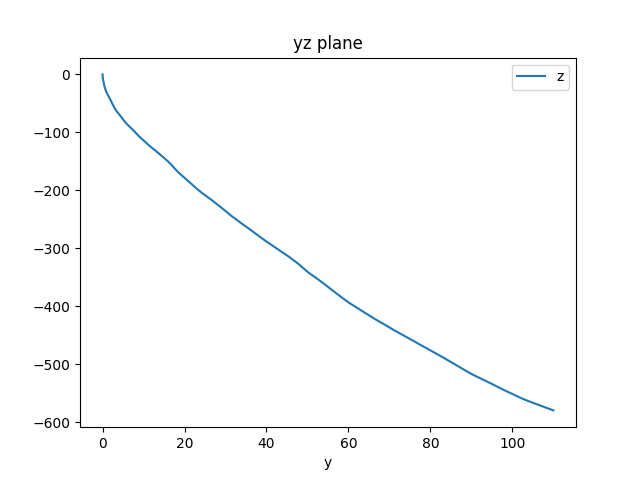

In [4]:
new_bh = simulate_borehole(sample_dist)
new_bh.plot.line(x='x', y='y', title='horizontal position')
new_bh.plot.line(x='x', y='z', title='xz plane')
new_bh.plot.line(x='y', y='z', title='yz plane')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(new_bh['x'], new_bh['y'], new_bh['z'], label='simulated borehole plot')
plt.show()

new_bh

In [41]:
def plot_multiples(borehole_list, names):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    for bh, name, in zip(borehole_list, names):
        ax.plot(bh['x'], bh['y'], bh['z'], label=name)

    plt.show()

In [50]:
def simulate_grid(nx=3, ny=3, spacing=15):
    borehole_list = []
    origins = []
    names = []
    
    for i in range(nx):
        for j in range(ny):
            name = "ABCDEFGHIJKLMNOPQRSUTVWXYZ"[i] + str(j)
            origin_x = i*spacing
            origin_y = j*spacing
            bh = simulate_borehole(sample_dist, origin_x = origin_x, origin_y = origin_y)
            bh['bh_name'] = name
            borehole_list.append(bh)
            origins.append([origin_x, origin_y])
            names.append(name)

    all_boreholes = pd.concat(borehole_list)
    return all_boreholes

#plot_multiples(borehole_list, names)

def check_for_clashes(all_boreholes, clash_distance=1):
    points = all_boreholes[['x', 'y', 'z']].values
    ids = all_boreholes['bh_name'].values
    clash_exists = False

    for bh in np.unique(ids):
        mask = (ids == bh)
        current = points[mask]
        others = points[~mask]

        tree = KDTree(others)
        idxs = tree.query_ball_point(current, r=clash_distance)
        if any(idxs):
            clash_exists = True

    return clash_exists

def run_n_sims(n_sims, clash_distance):
    print(f"clash_distance: {clash_distance}")
    n_clashes = 0
    for i in range(n_sims):
        all_boreholes = simulate_grid()
        if check_for_clashes(all_boreholes, clash_distance):
            n_clashes += 1

    print(f"n_sims: {n_sims}   n_clashes: {n_clashes}    ratio_clashes: {n_clashes / n_sims}")

run_n_sims(20, 0.5)
        
        


clash_distance: 0.5
n_sims: 20   n_clashes: 1    ratio_clashes: 0.05


In [46]:
points = all_boreholes[['x', 'y', 'z']].values
ids = all_boreholes['bh_name'].values

clash_distance = 1

for bh in np.unique(ids):
    mask = (ids == bh)
    current = points[mask]
    others = points[~mask]

    tree = KDTree(others)
    idxs = tree.query_ball_point(current, r=clash_distance)
    if any(idxs):
        print(bh)
        current_idxs = []
        for i, idx_list in enumerate(idxs):
            if any(idx_list):
                print(i, idx_list)
                print(points[i])


In [38]:
n1 = 1429
n2 = 828
print(ids[n1], points[n1])
print(ids[n2], points[n2])

A2 [  10.37217      33.15403    -226.61737779]
A1 [  12.69736      12.07617    -226.34670281]


# Testing Area

In [ ]:
noise = pd.DataFrame({"x": [0], "y":[0]})

for i in range(100):
    nx = opensimplex.noise2(i)

